# Single-Image Super-Resolution on Grayscale Images
**Author:** [Richard Hemphill](mailto:rhemphill2019@my.fit.ed)<br>
**School:** [Florida Institute of Technology](https://www.fit.edu/)<br>
**Class:** [ECE5268 Theory of Neural Networks](http://catalog.fit.edu/preview_course_nopop.php?catoid=1&coid=927&)<br>
**Instructor:** [Dr. Georgios C. Anagnostopoulos](https://www.fit.edu/faculty-profiles/3/georgios-anagnostopoulos/)<br>
**Assignment:** Individual Class Project<br>

# Table of Contents
1. [Concept](#Concept)
    1. [Description](#Concept-Description)
    1. [Goal](#Concept-Goal)
1. [References](#References)
    1. [Architecture](#References-Architecture)
    1. [Dataset](#References-Dataset)
    1. [Example](#References-Example)
1. [Architecture](#Architecture)
1. [Code](#Code)
    1. [Configure](#Code-Configure)
    1. [Utility](#Code-Utility)
    1. [Prepocessing](#Code-Prepocessing)
    1. [Model](#Code-Model)
    1. [Train](#Code-Train)
    1. [Test](#Code-Test)
1. [Results](#Results)

# Concept<a class="anchor" id="Concept"></a>

## Description<a class="anchor" id="Concept-Description"></a>
Using small-sized grayscale images, construct a neural network architecture that will downscale (magnify) the images by a factor of 2.  The following image shows the concept where a magnified image maintains the reduces resolution and thus blury.  A neural network can be trained to enhance features in the image so that upon magnification (i.e. super resolution) it looks close to the original.

![description](figures/description.png)

## Goal<a class="anchor" id="Concept-Goal"></a>
The goal of the project is to constuct Python code to import and extract a dataset, take shrinken images with the original and train a CNN (Convolutional Neural Network) to magnify and subsequently enhance an image back to the orignal as shown in the following figure.

![goal](figures/goal.png)

# References<a name="References"></a>

## Architecute<a name="References-Architecute"></a>
The following paper is a trade study to show that a lightweigh structure can perform to a more deeper (i.e. more layers) network.  If trained sufficiently, it can outperform classical magnification (e.g. bicubic interpolation). 
> C. Dong, C. C. Loy, K. He and X. Tang, "[Image Super-Resolution Using Deep Convolutional Networks](https://ieeexplore.ieee.org/document/7115171)," in IEEE Transactions on Pattern Analysis and Machine Intelligence, vol. 38, no. 2, pp. 295-307, 1 Feb. 2016, doi: 10.1109/TPAMI.2015.2439281.

## Dataset<a name="References-Dataset"></a>
The following [Kaggle](https://www.kaggle.com/) dataset contains about 800 taining and 260 test images.  They are all greyscale and there is no license on the images.  It shows how to produce a model to perform super resolution.
> Goose, Mr. “AlexOnly_Greyscale,” January 22, 2020. https://www.kaggle.com/spaceengineer1/alexonly-greyscale. 

## Example<a name="References-Example"></a>
The following example code came from the [Keras code examples](https://keras.io/examples/).  
> Long, Xingyu. “Image Super-Resolution Using an Efficient Sub-Pixel CNN,” 2020. https://keras.io/examples/vision/super_resolution_sub_pixel/. 

# Architecture<a class="anchor" id="Architecture"></a>

tbd

# Code<a class="anchor" id="Code"></a>

## Configure<a class="anchor" id="Code-Configure"></a>

### Imports

In [1]:
# General

import math
import random

# Path
import os.path
import shutil
import glob
from zipfile import ZipFile

# Math
import numpy as np

# Image
from pylab import rcParams
import matplotlib.pyplot as plt
from PIL.Image import BICUBIC

# Dataset
from kaggle.api.kaggle_api_extended import KaggleApi

# Model
from tensorflow import keras
from tensorflow.test import gpu_device_name
from tensorflow.image import resize
from tensorflow.image import psnr
from tensorflow.nn import depth_to_space
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.python.client import device_lib

### Constants

In [2]:
# training parameters
EPOCHS = 20
BATCH_SIZE = 10
VALIDATION_SPLIT = 0.2

# largest integer use for seeding the random number generator
RANDRANGE_STOP = 10000

# data set parameters
IMAGE_SET_OWNER = 'spaceengineer1'
IMAGE_SET_FILE = 'alexonly-greyscale'
ZIP_EXTENSION = 'zip'
TRAIN_FOLDER = 'train'
TEST_FOLDER = 'test'

# image parameters
IMAGE_EXTENSION = 'jpg'
RESCALE_FACTOR = 255.0  # normalize pixels
CHANNELS = 1            # greyscale
ORIG_IMG_SIZE = 64      # 64x64
UPSCALE_FACTOR = 2      # magnification factor
LOW_RES_IMG_SIZE = int(ORIG_IMG_SIZE/UPSCALE_FACTOR)

# directoryies
CURRENT_DIRECTORY = '.'
FIGURE_DIRECTORY = 'figures/'

# results
TRAINING_PLOT = 'SuperResTrain.png'
TEST_RESULT = 'TestSetExample.png'

### Setup

In [3]:
# set figure's width 8 inches, and its height 8 inches
rcParams['figure.figsize'] = 8, 8

In [4]:
# Check if Tensorflow is using GPU
if gpu_device_name():
    print('Default GPU Device: {}'.format(gpu_device_name()))
else:
    print("Please install GPU version of TensorFlow")

Default GPU Device: /device:GPU:0


## Utility<a class="anchor" id="Code-Utility"></a>

In [5]:
def ImageNorm(image):
    image = image/RESCALE_FACTOR
    return image

In [6]:
def Shrink(input):
    return resize(input,[LOW_RES_IMG_SIZE,LOW_RES_IMG_SIZE],method='area')

In [7]:
def MagnifyImage(model, lowResImg):
    lowResArr = img_to_array(lowResImg)
    lowResArr = lowResArr.astype('float32')/RESCALE_FACTOR
    lowResArr = np.expand_dims(lowResArr, axis=0)
    hiResArr = model.predict(lowResArr)
    hiResArr *= RESCALE_FACTOR
    hiResArr = hiResArr.reshape((ORIG_IMG_SIZE,ORIG_IMG_SIZE,CHANNELS))
    hiResImg = array_to_img(hiResArr)
    return hiResImg

In [8]:
# Extract raw image set
def DownloadImageSet(imageSetOwner = IMAGE_SET_OWNER, imageSetFile = IMAGE_SET_FILE):
    zipFile = '{}.{}'.format(imageSetFile, ZIP_EXTENSION)
    if not os.path.isfile(zipFile):
        # connect to the Kaggle Database and download dataset
        api = KaggleApi()
        api.authenticate()
        api.dataset_download_files('{}/{}'.format(imageSetOwner, imageSetFile))
    # extract the dataset
    zf = ZipFile(zipFile)
    topDir = ''.join({item.split('/')[0] for item in zf.namelist()})
    if not os.path.isdir(topDir):
        zf.extractall() 
        zf.close()

    testDirPre = os.path.join(topDir,TEST_FOLDER)
    if os.path.isdir(testDirPre):
        if not os.path.isdir(TEST_FOLDER):
            shutil.move(testDirPre, CURRENT_DIRECTORY)
        
    return topDir, TEST_FOLDER

## Prepocessing<a class="anchor" id="Code-Prepocessing"></a>

In [9]:
# Pre Process Images
trainFolder, testFolder = DownloadImageSet()

In [10]:
testImgPaths = glob.glob('{}/*.{}'.format(testFolder, IMAGE_EXTENSION))

In [11]:
trainSet = image_dataset_from_directory(
    directory=trainFolder,
    batch_size=BATCH_SIZE,
    image_size=(ORIG_IMG_SIZE,ORIG_IMG_SIZE),
    validation_split=VALIDATION_SPLIT,
    subset='training',
    color_mode='grayscale',
    seed=random.randrange(RANDRANGE_STOP),
    label_mode=None)

Found 804 files belonging to 1 classes.
Using 644 files for training.


In [12]:
trainSet = trainSet.map(ImageNorm)
trainSet = trainSet.map(lambda x: (Shrink(x),x))

In [13]:
valSet = image_dataset_from_directory(
    directory=trainFolder,
    batch_size=BATCH_SIZE,
    image_size=(ORIG_IMG_SIZE,ORIG_IMG_SIZE),
    validation_split=VALIDATION_SPLIT,
    subset='validation',
    color_mode='grayscale',
    seed=random.randrange(RANDRANGE_STOP),
    label_mode=None)

Found 804 files belonging to 1 classes.
Using 160 files for validation.


In [14]:
valSet = valSet.map(ImageNorm)
valSet = valSet.map(lambda x: (Shrink(x),x))

## Model<a class="anchor" id="Code-Model"></a>

In [15]:
class SuperCallback(keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        # Initialize the lists for holding the logs, losses and accuracies
        self.loss = []
        self.acc = []
        self.valLoss = []
        self.valAcc = []
        self.logs = []
        self.psnr = []

    # Store PSNR value in each epoch.
    def on_epoch_begin(self, epoch, logs=None):
        self.psnrEpoch = []

    # Print result of PNSR per Epoch
    def on_epoch_end(self, epoch, logs=None):
        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.loss.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))
        self.valLoss.append(logs.get('val_loss'))
        self.valAcc.append(logs.get('val_acc'))
        self.psnr.append(np.mean(self.psnrEpoch))

    # Aggregate PNSR per batch run
    def on_test_batch_end(self, batch, logs=None):
        self.psnrEpoch.append(10 * math.log10(1 / logs["loss"]))

    def on_train_end(self, logs=None):
        # Before plotting ensure at least 2 epochs have passed
        if len(self.loss) > 1:
            N = np.arange(0, len(self.loss))
            fig, ax = plt.subplots()
            ax.plot(N, self.loss, label='Train Loss', color='blue')
            ax.plot(N, self.valLoss, label='Val Loss', color='red')
            ax.set_ylabel("Loss/Accuracy")
            ax.legend(loc='upper left')
            ax2=ax.twinx()
            ax2.plot(N, self.psnr, label='PSNR', color='green')
            ax2.set_ylabel('Peak Signal to Noise Ratio')
            ax2.legend(loc='upper right')
            ax.set_xlabel("Epoch #")
            plt.savefig(FIGURE_DIRECTORY + TRAINING_PLOT)
            plt.show()
            plt.close()

In [16]:
def SuperResolution(upscaleFactor=UPSCALE_FACTOR, channels=CHANNELS):

    conv2dArgs = {"activation": "relu","kernel_initializer": "Orthogonal","padding": "same"}

    inputs = keras.Input(shape=(None, None, channels))
    x = keras.layers.Conv2D(filters=64, kernel_size=9, **conv2dArgs)(inputs)
    x = keras.layers.Conv2D(filters=32, kernel_size=1, **conv2dArgs)(x)
    x = keras.layers.Conv2D(filters=(channels * (upscaleFactor ** 2)), kernel_size=5, **conv2dArgs)(x)
    outputs = depth_to_space(x, upscaleFactor)

    return keras.Model(inputs, outputs)

In [17]:
sr = SuperResolution()
sr.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 64)    5248      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 32)    2080      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 4)     3204      
_________________________________________________________________
tf.nn.depth_to_space (TFOpLa (None, None, None, 1)     0         
Total params: 10,532
Trainable params: 10,532
Non-trainable params: 0
_________________________________________________________________


## Train<a class="anchor" id="Code-Train"></a>

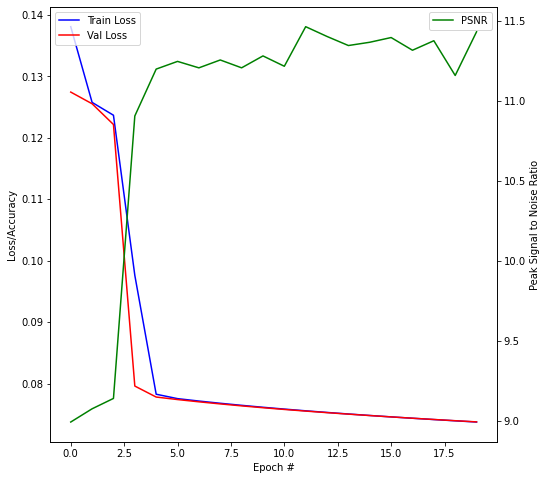

In [18]:
sr.compile(optimizer=keras.optimizers.SGD(learning_rate=0.001), loss=keras.losses.MeanSquaredError())
sr.fit(trainSet, epochs=EPOCHS, callbacks=[SuperCallback()], validation_data=valSet, use_multiprocessing=True, verbose=0)

## Test<a class="anchor" id="Code-Test"></a>

In [19]:
def DisplayTestImg(testImg,lowResImg,biCubicImg,superResImg):
    fig = plt.figure()
    ax1 = fig.add_subplot(2,2,1)
    ax1.imshow(testImg,cmap='gray')
    ax1.set_title('Test Image')
    ax2 = fig.add_subplot(2,2,2)
    ax2.imshow(lowResImg,cmap='gray')
    ax2.set_title('Low Res Image')
    ax3 = fig.add_subplot(2,2,3)
    ax3.imshow(biCubicImg,cmap='gray')
    ax3.set_title('Bicubic Image')
    ax4 = fig.add_subplot(2,2,4)
    ax4.imshow(superResImg,cmap='gray')
    ax4.set_title('Super Res Image')
    plt.savefig(FIGURE_DIRECTORY + TEST_RESULT)

In [20]:
totalBiCubicPsnr = 0
totalSuperPsnr = 0

for idx, testImgPath in enumerate(testImgPaths):
    img = load_img(testImgPath, color_mode='grayscale', target_size=(ORIG_IMG_SIZE,ORIG_IMG_SIZE))
    lowResImg = img.resize((LOW_RES_IMG_SIZE,LOW_RES_IMG_SIZE), resample=BICUBIC)
    biCubicImg = lowResImg.resize((ORIG_IMG_SIZE,ORIG_IMG_SIZE), resample=BICUBIC)
    superResImg = MagnifyImage(sr,lowResImg)

    biCubicPsnr = psnr(img_to_array(biCubicImg), img_to_array(img), max_val=255)
    superPsnr = psnr(img_to_array(superResImg), img_to_array(img), max_val=255)

    totalBiCubicPsnr += biCubicPsnr
    totalSuperPsnr += superPsnr

In [21]:
print('Magnify (BiCubic) PSNR: {:.3}'.format(totalBiCubicPsnr/(idx+1)))
print('Super Resolution PSNR: {:.3}'.format(totalSuperPsnr/(idx+1)))

Magnify (BiCubic) PSNR: 25.1
Super Resolution PSNR: 10.8


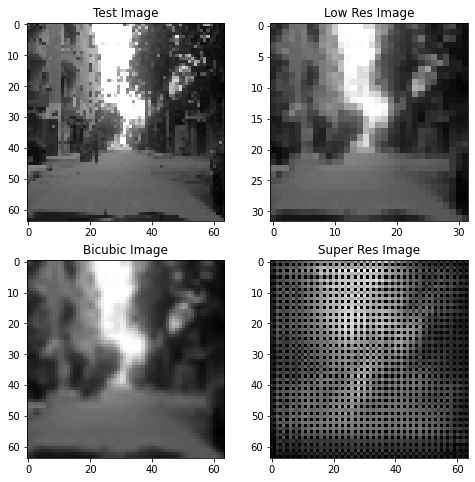

In [22]:
DisplayTestImg(img,lowResImg,biCubicImg,superResImg)

# Results<a class="anchor" id="Results"></a>

[description]: figures/description.png